In [47]:
import numpy as np
from matplotlib import pyplot as plt
import cv2
from numpy import exp,pi,power,sqrt,arctan,tan
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号


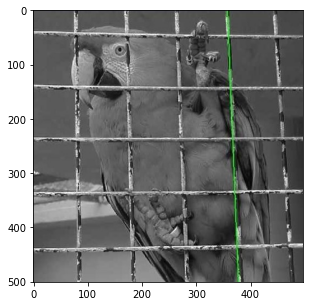

In [39]:
image = cv2.imread("./image/hough_1.jpg")
plt.figure(figsize=(5, 5))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()


高斯核：
 [[0.00296902 0.01330621 0.02193823 0.01330621 0.00296902]
 [0.01330621 0.0596343  0.09832033 0.0596343  0.01330621]
 [0.02193823 0.09832033 0.16210282 0.09832033 0.02193823]
 [0.01330621 0.0596343  0.09832033 0.0596343  0.01330621]
 [0.00296902 0.01330621 0.02193823 0.01330621 0.00296902]]


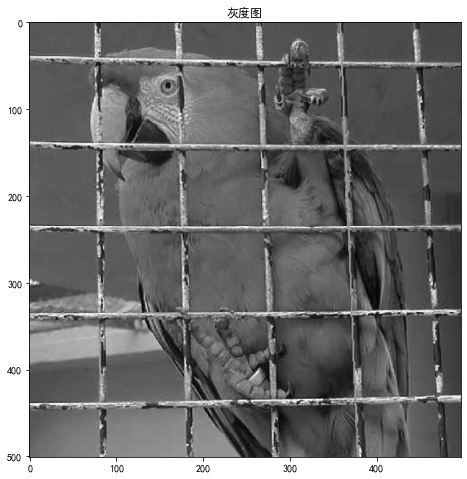

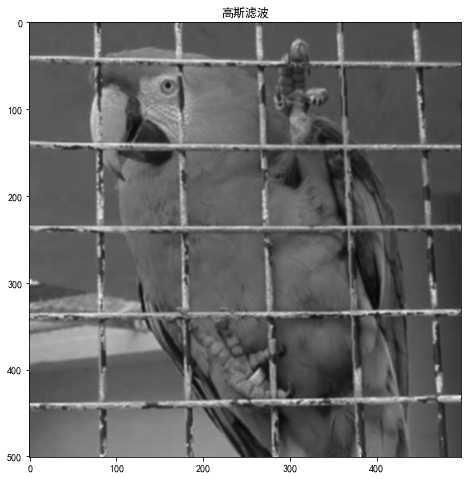

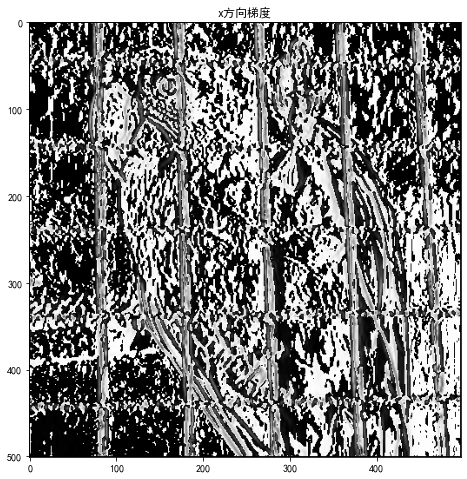

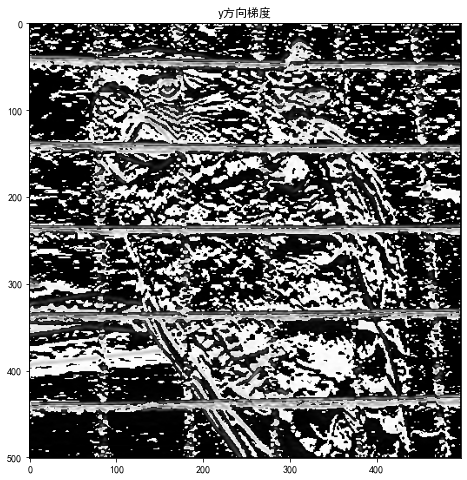

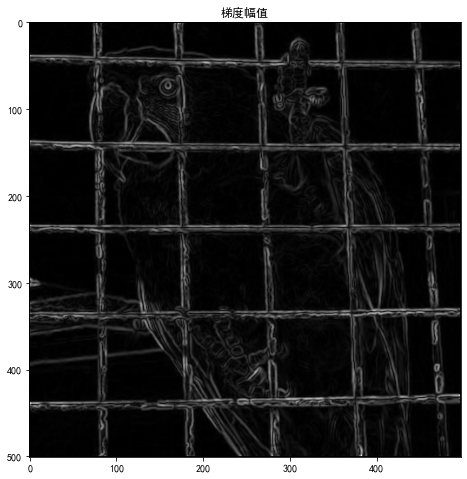

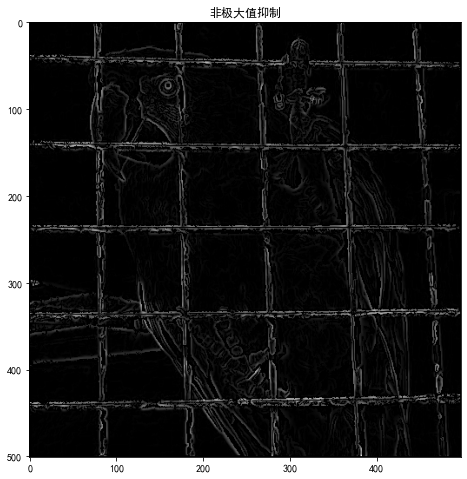

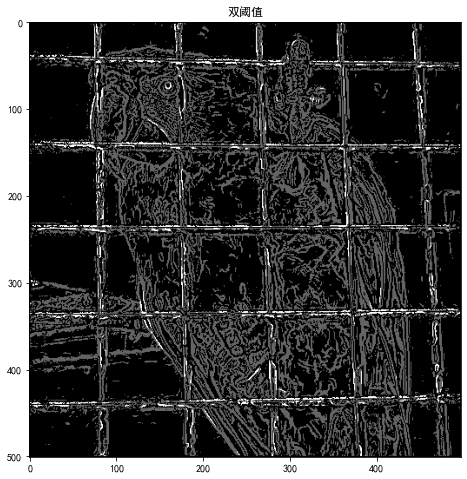

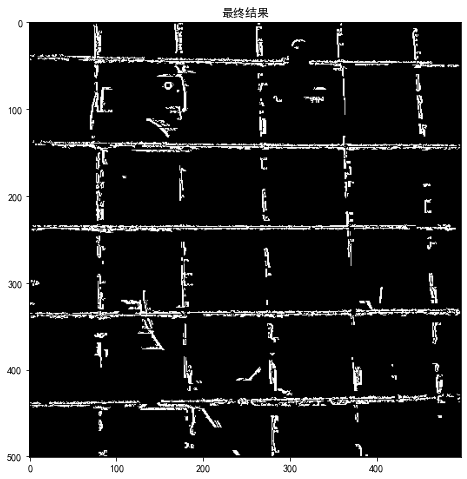

In [103]:
class Canny:
    g_kernel = None
    g_x = None
    g_y = None
    g = None
    theta = None
    def __init__(self, g_dim = 5):
        # 初始化高斯核
        gaussian_fun = lambda x,y,p = 1: 1/(2*pi*power(p, 2)) * \
            exp((-power(x, 2)-power(y, 2))/(2*power(p, 2)))
        g_kernel = []
        for y in range(g_dim):
            row = []
            for x in range(g_dim):
                j, i = y - int(g_dim/2), x - int(g_dim/2)
                row.append(gaussian_fun(i, j))
            g_kernel.append(row)
        g_kernel = np.array(g_kernel)
        g_kernel = g_kernel/g_kernel.sum()
        self.g_kernel = g_kernel
        print("高斯核：\n", g_kernel)
    def calculateEdges(self, image_gray, threshold_btm = 80, threshold_top = 100):
        '''
            计算边缘
        '''
        self.paint(cv2.cvtColor(image_gray, cv2.COLOR_GRAY2RGB),"灰度图")
        # 高斯滤波，边缘点为原图的值
        image_g = self.convolute(
            image_gray, self.g_kernel, lambda y, x: image_gray[y, x], dtype=np.uint8)
        self.paint(cv2.cvtColor(image_g, cv2.COLOR_GRAY2RGB), "高斯滤波")
        # 计算x,y方向的梯度
        kerner_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
        kerner_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
        g_x = self.g_x = self.convolute(image_g,kerner_x)
        self.paint(cv2.cvtColor(np.array(g_x/g_x.max()*255, dtype=np.uint8),
                   cv2.COLOR_GRAY2RGB), "x方向梯度")
        g_y = self.g_y = self.convolute(image_g,kerner_y)
        self.paint(cv2.cvtColor(np.array(g_y/g_y.max()*255, dtype=np.uint8),
                   cv2.COLOR_GRAY2RGB), "y方向梯度")
        # 计算梯度方向
        theta = self.theta = np.zeros_like(g_x, dtype=np.float64)
        self.foreach_image(theta, self.get_gradient)
        # 计算梯度幅值
        g = self.g = np.zeros_like(g_x,dtype=np.float64)
        self.foreach_image(g, lambda y, x: sqrt(
            power(g_x[y, x], 2)+power(g_y[y, x], 2)))
        self.paint(cv2.cvtColor(np.array(g/g.max()*255, dtype=np.uint8),
                   cv2.COLOR_GRAY2RGB), "梯度幅值")
        # 非极大值抑制
        g_max = np.zeros_like(g)
        self.foreach_image(g_max, self.linear_interpolation)
        g_max = np.array(g_max/g_max.max()*255, dtype=np.uint8)
        self.paint(cv2.cvtColor(g_max,cv2.COLOR_GRAY2RGB), "非极大值抑制")
        # 双阈值
        g_double_threshold = np.zeros_like(g_max,dtype=np.uint8)
        self.foreach_image(g_double_threshold, lambda y,
                           x: 0 if g_max[y, x] < threshold_btm else 255 if g_max[y, x] > threshold_top else 100)
        self.paint(cv2.cvtColor(g_double_threshold, cv2.COLOR_GRAY2RGB), "双阈值")

        # 滞回性
        g_rtn = np.zeros_like(g_double_threshold, dtype=np.uint8)
        self.dfs(g_rtn, g_double_threshold)
        self.paint(cv2.cvtColor(g_rtn,cv2.COLOR_GRAY2RGB), "最终结果")

        # 二值化
        return g_rtn

    def linear_interpolation(self,y, x):
        theta, g_x, g_y,g = self.theta,self.g_x,self.g_y,self.g
        height, width = g.shape
        t, p = theta[y, x], g[y, x]
        if (t > -pi/4 and t < pi/4) or (t > 3/4*pi and t < 5/4*pi) :
            x_c = x + (-1 if g_x[y, x] < 0 else 1)
            y_c = y + abs(tan(t)) * (-1 if g_y[y, x] < 0 else 1)
        elif t == pi/2 or t == -pi/2:
            y_c = y + (-1 if g_y[y, x] < 0 else 1)
            x_c = x
        else:
            y_c = y + (-1 if g_y[y, x] < 0 else 1)
            x_c = x + abs(tan(t)) * (-1 if g_x[y, x] < 0 else 1)
        x_0, y_0 = int(x_c), int(y_c)
        x_1, y_1 = int(x_c + 0.5), int(y_c + 0.5)
        if x_0 > 0 and x_0 < width - 1 and y_0 > 0 and y_0 < height - 1 \
                and x_1 > 0 and x_1 < width - 1 and y_1 > 0 and y_1 < height - 1:
            d_0 = abs(x_c-x_0 + y_c-y_0)
            return p if p > (g[y_0, x_0] - d_0*(g[y_0, x_0]-g[y_1, x_1])) else 0
        else:
            return 0
    def get_gradient(self,y, x):
        g_x,g_y = self.g_x,self.g_y
        if g_x[y, x] == 0:
            if g_y[y, x] == 0:
                return 0
            else:
                return pi/2 if g_y[y, x] > 0 else -pi/2
        else:
            t = arctan(g_y[y, x]/g_x[y, x])
            return t if g_x[y, x] > 0 else t + pi
    def foreach_image(self, image, assignment=lambda y,x:0):
        h,w = image.shape
        for j in range(h):
            for i in range(w):
                image[j,i] = assignment(j,i)
    def convolute(self, image_gray, kernel, padding_method=lambda y, x: 0,dtype=np.float64):
        '''
            卷积
        '''
        h,w = image_gray.shape
        k_h,k_w = kernel.shape
        k_h_half, k_w_half = int(k_h/2), int(k_w/2)
        image_dst = np.zeros_like(image_gray, dtype=dtype)
        for y,rows in enumerate(image_dst):
            for x,cell in enumerate(rows):
                if y - k_h_half < 0 or y + k_h_half > h-1 or x - k_w_half < 0 or x + k_w_half > w-1:
                    image_dst[y,x] = padding_method(y,x)
                else:
                    sum = 0
                    for j,k_rows in enumerate(kernel):
                        for i,k_cell in enumerate(k_rows):
                            sum = sum + k_cell * \
                                image_gray[y-k_h_half+j, x-k_w_half+i]
                    image_dst[y,x] = sum
        return image_dst

    def dfs(self, image, g_double_threshold):
        flag = np.zeros_like(image, dtype=np.uint8)
        h, w = image.shape
        for j in range(h):
            for i in range(w):
                if g_double_threshold[j, i] != 255:
                    continue
                stack = list()
                stack.append((j,i))
                while len(stack) > 0:
                    y,x = stack.pop()
                    image[y,x] = 255
                    flag[y, x] = 1
                    for yy in range(j-1,j+2):
                        for xx in range(x-1,x+2):
                            if xx > 0 and xx < w-1 and yy > 0 and yy < h-1 and not (y == yy and x == xx):
                                if flag[yy,xx] == 1:continue
                                if g_double_threshold[yy, xx] == 100:
                                    stack.append((yy,xx))

        pass
    def paint(self, image, title):
        plt.figure(figsize=(8, 8))
        plt.title(title)
        plt.imshow(image)
        plt.show()
# 灰度化
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
canny = Canny()
# canny边缘检测
edges = canny.calculateEdges(image_gray, 5, 90)
    


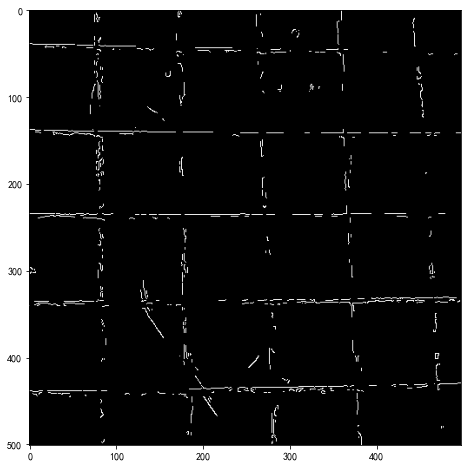

In [104]:
# opencv的canny边缘检测效果
edges = cv2.Canny(image, threshold1=500, threshold2=600)
edges_show = cv2.cvtColor(edges, cv2.COLOR_GRAY2RGB)
plt.figure(figsize=(8, 8))
plt.imshow(edges_show)
plt.show()